# Unitary Optimization for Two-Level Systems

**Author:** pmpoggi @ strath (February 2024)

This notebook uses GRAPE + BFGS to optimize unitaries for a two-level system.

## Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.linalg as alg
import scipy.optimize as optim

## General Functions and Definitions

Define the basic quantum mechanical operators and utility functions for two-level systems.

In [2]:
# Dimension of Hilbert space
dim = 2

# Pauli matrices
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)
paulis = {'x': X, 'y': Y, 'z': Z}
iden2 = np.identity(dim)

def herm(A):
    """Return Hermitian conjugate of matrix A"""
    return np.conjugate(A.T)

## System Functions and Parameters

Define the time-dependent Hamiltonian with parametric control and its gradient.

In [3]:
# System parameters
Omega = 1.
T0 = 2*np.pi/Omega  # measure time in this unit

def H(x): 
    """Time-dependent Hamiltonian: H = 0.5*Ω*(cos(x)*X + sin(x)*Y)"""
    return 0.5*Omega*(np.cos(x)*X + np.sin(x)*Y)

def gradH(x):
    """Gradient of Hamiltonian with respect to control parameter x"""
    derH_x = 0.5*Omega*(-np.sin(x)*X + np.cos(x)*Y)
    return derH_x

def gen_propag(x):
    """Generate time evolution propagator for control field x"""
    Ut = np.empty([Nts+1, dim, dim], dtype=complex)
    Ut[0, :, :] = np.identity(dim)
    
    for kt in range(Nts):
        Udt = alg.expm(-1j*H(x[kt])*dt)
        Ut[kt+1] = np.dot(Udt, Ut[kt])
    
    return Ut

## Optimization and Evolution Parameters

Set up the optimization parameters and define the target unitary operation.

In [4]:
# Optimization parameters
method_gr = 'L-BFGS-B'  # BFGS or L-BFGS-B
grad_tol = 1e-06  # tolerance for gradient
Nts = 10  # number of time-steps
Nattempts = 3  # number of random initializations

# Time evolution parameters
Tfs = np.linspace(0.05, 1.5, 40)  # for fidelity vs time plot
# Tfs = [1]  # single time evolution
fide_opt = np.ones(len(Tfs))

# Target unitary parameters
fac = 1/8
# angs = np.array([1/32, 1/16, 1/8, 1/4, 0.5, 2/3, 1])*np.pi
ang = fac*np.pi  # angle of target Pauli rotation
axis = 'z'  # axis of target Pauli rotation
ind = 0  # 0 for random, 1 for linear initial guess
guess = ['random', 'linear']

# Define target unitary: exp(-i * 0.5 * σ_axis * angle)
Utarg = alg.expm(-1j*0.5*paulis[axis]*ang)

print(f"Target unitary: {axis}-rotation by {ang/np.pi:.3f}π")
print(f"Initial guess method: {guess[ind]}")

Target unitary: z-rotation by 0.125π
Initial guess method: random


## Optimization Functions

Define the cost function and its gradient for unitary fidelity optimization.

In [5]:
def Jcost(x):
    """Cost function: 1 - |Tr(U†_target * U_evolved)|²/d²"""
    UT = gen_propag(x)[-1]
    z = np.trace(np.dot(UT, herm(Utarg))) 
    cost_step = 1 - abs(z)**2/dim**2 
    return cost_step

def Jgrad(x):
    """Gradient of the cost function with respect to control fields"""
    Ut = gen_propag(x)
    z = np.trace(np.dot(Ut[-1], herm(Utarg)))/dim

    # Compute gradient w/respect to fields
    gradi_fields = np.zeros(Nts)
    
    for kj in range(Nts):
        hj = H(x[kj])
        
        # Eigendecomposition of Hamiltonian
        [vals, vecs] = alg.eigh(hj)
        dhj_daj = gradH(x[kj])
        
        # Transform derivative to Hamiltonian basis
        dhj_daj_rb = np.dot(herm(vecs), np.dot(dhj_daj, vecs))

        # Compute matrix elements of propagator derivative
        g_h_rb = np.zeros([dim, dim], dtype=complex)
        for n in range(dim):
            for m in range(dim):
                if abs(vals[m] - vals[n]) < 1e-4:
                    g_h_rb[n, m] = -1j*dt*dhj_daj_rb[n, m]*np.exp(-1j*dt*vals[n])
                else:
                    g_h_rb[n, m] = dhj_daj_rb[n, m]*(np.exp(-1j*dt*vals[n]) - 
                                                    np.exp(-1j*dt*vals[m]))/(vals[n] - vals[m])
        
        # Transform back to canonical basis
        g_h = np.dot(vecs, np.dot(g_h_rb, herm(vecs)))
        duj_daj = g_h
        
        # Compute full propagator derivative
        Ufw = Ut[kj]
        Ubw = np.dot(Ut[-1], herm(Ut[kj+1]))
        dU_daj = np.dot(Ubw, np.dot(duj_daj, Ufw))
        
        # Compute gradient element
        dz_daj = np.trace(np.dot(herm(Utarg), dU_daj))/dim
        gradi_fields[kj] = -2*np.real(dz_daj*np.conjugate(z))
        
    return gradi_fields

## Main Optimization Loop

Run the optimization for different evolution times and initial guesses.

In [6]:
# Initialize timing and optimization variables
t_script_0 = time.time()
field_opt = 0

# Storage for multiple attempts
cost_run = np.ones([Nattempts, len(Tfs)])

# Main optimization loop
for nA in range(Nattempts):
    for mT in range(len(Tfs))[::-1]:  # Start from longest time

        Tf = Tfs[mT]*T0
        t = np.linspace(0., Tf, Nts+1)
        tfield = np.linspace(0., Tf, Nts)
        dt = t[1] - t[0]
        
        print("Run %d of %d, attempt %d of %d" % (mT+1, len(Tfs), nA+1, Nattempts))

        # Initialize field for first T value
        if mT == len(Tfs)-1:
            if ind == 0:  # random initialization
                field_x0 = 2*np.pi*(np.random.rand(Nts) - 0.5)
            elif ind == 1:  # linear initialization
                field_x0 = np.linspace(-np.pi, np.pi, Nts)
            cost_x0 = Jcost(field_x0)
        else:
            field_x0 = field_opt
              
        # Run optimization with bounds on control parameters
        opt_result = optim.minimize(Jcost, x0=field_x0, method=method_gr, jac=Jgrad,
                                  bounds=optim.Bounds(lb=-np.pi, ub=np.pi),
                                  options={'gtol': grad_tol, 'disp': False})
       
        # Store results
        field_opt = opt_result['x']
        final_fide = opt_result['fun']
        print(final_fide)
        
        cost_run[nA, mT] = final_fide
        
        # Keep the best fidelity of all attempts
        if final_fide <= np.amin(cost_run[:, mT]):
            fide_opt[mT] = final_fide

Run 40 of 40, attempt 1 of 3
-8.881784197001252e-16
Run 39 of 40, attempt 1 of 3
1.2158274387275014e-10
Run 38 of 40, attempt 1 of 3
1.3766765505351941e-14
Run 37 of 40, attempt 1 of 3
1.6142642778049776e-13
Run 36 of 40, attempt 1 of 3
7.176481631177012e-13
Run 35 of 40, attempt 1 of 3
5.890843368661081e-13
Run 34 of 40, attempt 1 of 3
6.705747068735946e-14
Run 33 of 40, attempt 1 of 3
6.661338147750939e-16
Run 32 of 40, attempt 1 of 3
0.0
Run 31 of 40, attempt 1 of 3
1.4654943925052066e-14
Run 30 of 40, attempt 1 of 3
1.5587531265737198e-13
Run 29 of 40, attempt 1 of 3
2.1604940059205546e-13
Run 28 of 40, attempt 1 of 3
1.6298074001497298e-13
Run 27 of 40, attempt 1 of 3
7.633893517322576e-13
Run 26 of 40, attempt 1 of 3
3.4638958368304884e-14
Run 25 of 40, attempt 1 of 3
1.0413891970983968e-13
Run 24 of 40, attempt 1 of 3
2.2293278334473143e-13
Run 23 of 40, attempt 1 of 3
1.4788170688007085e-13
Run 22 of 40, attempt 1 of 3
9.325873406851315e-15
Run 21 of 40, attempt 1 of 3
6.598277

## Visualization and Results

Plot the optimization results - either the optimal control fields or the fidelity vs time.

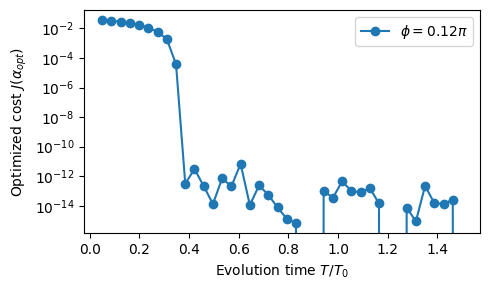

In [7]:
# Plotting parameters
colore = ['b', 'tab:orange']
lab = ['random', 'linear']

# Plot optimal control fields for single time evolution
if len(Tfs) == 1:
    plt.figure(1, figsize=(4, 3))
    plt.title("angle = %.2f, cost0=%.5f, costF=%.2E" % (ang/np.pi, cost_x0, final_fide), size=8)
    plt.stairs(field_x0, t/(T0/2), baseline=None, linestyle='--', 
              linewidth=1.5, color='0.6', label='Initial')
    plt.stairs(field_opt, t/(T0/2), baseline=None, linewidth=2, 
              color=colore[ind], label=f'Optimized ({lab[ind]})')
    plt.ylim([-1.1*np.pi, 1.1*np.pi])
    plt.yticks([-np.pi, 0, np.pi], [r'$-\pi$', '$0$', r'$\pi$'])
    plt.xlabel(r"Time $t\Omega/\pi$")
    plt.ylabel(r"Field $\alpha(t)$")
    plt.legend()
    plt.tight_layout()

# Plot fidelity vs evolution time
if len(Tfs) > 1:
    plt.figure(1, figsize=(5, 3))
    plt.semilogy(Tfs, fide_opt, 'o-', label=r"$\phi=%.2f \pi$" % (ang/np.pi))
    plt.xlabel(r"Evolution time $T/T_0$")
    plt.ylabel(r"Optimized cost $J(\alpha_{opt})$")
    plt.legend()
    plt.tight_layout()

plt.show()

## Analysis and Results Summary

Display key results and final unitary fidelity.

In [8]:
# Calculate final unitary and compare with target
U_final = gen_propag(field_opt)[-1]
fidelity = abs(np.trace(np.dot(U_final, herm(Utarg))))**2 / dim**2

print("\n=== OPTIMIZATION RESULTS ===")
print(f"Target operation: {axis.upper()}-rotation by {ang/np.pi:.4f}π")
print(f"Evolution time: {Tfs[0]:.3f} T₀")
print(f"Number of time steps: {Nts}")
print(f"Initial guess method: {guess[ind]}")
print(f"\nFinal cost function: {final_fide:.2e}")
print(f"Final unitary fidelity: {fidelity:.6f}")
print(f"Process fidelity: {fidelity:.6f}")
print(f"\nOptimization completed in {Nattempts} attempts")

# Display target and achieved unitaries
print("\n=== TARGET UNITARY ===")
print(Utarg)
print("\n=== ACHIEVED UNITARY ===")
print(U_final)
print("\n=== DIFFERENCE ===")
print(U_final - Utarg)


=== OPTIMIZATION RESULTS ===
Target operation: Z-rotation by 0.1250π
Evolution time: 0.050 T₀
Number of time steps: 10
Initial guess method: random

Final cost function: 3.65e-02
Final unitary fidelity: 0.963480
Process fidelity: 0.963480

Optimization completed in 3 attempts

=== TARGET UNITARY ===
[[0.98078528-0.19509032j 0.        +0.j        ]
 [0.        +0.j         0.98078528+0.19509032j]]

=== ACHIEVED UNITARY ===
[[ 0.99993727-0.00433798j -0.00798383+0.0065491j ]
 [ 0.00798383+0.0065491j   0.99993727+0.00433798j]]

=== DIFFERENCE ===
[[ 0.01915199+0.19075235j -0.00798383+0.0065491j ]
 [ 0.00798383+0.0065491j   0.01915199-0.19075235j]]
